## Feature Extraction

### Convolutional Neural Network
CNN algorithms recognize patterns in spatial data, which works best with images. So we will be converting the original audio data into spectrograms which are graphs that visually represent the change in frequency over time.<br>
We are starting with 1000 wav files for our data. I will convert these into mel-spectrogrmas. we chose mel-spectrograms specifically because they measure the mel scale instead of frequency along the y-axis. Also changing the color of the points based off the decibal scale not the amplitude of the wave. These spectrograms focus more on what humans will actually here making it more ideal for genre classification.<br>
This splits 1 clip of 30 seconds into 28 different mel-spectrograms. 

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to convert a 3-second audio segment to a mel-spectrogram
def save_mel_spectrogram(y, sr, output_image_path, n_mels=128):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Paths
PATH_MP3 = "./data/genres_original/"
PATH_IMG = "./data/genres_img/"
sr = 22050  # Sampling rate
skip = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae']  

os.makedirs(PATH_IMG, exist_ok=True)

# Convert all WAV files to mel spectrograms (split into 3-second segments)
for genre in os.listdir(PATH_MP3):
    if genre not in skip:
        genre_path = os.path.join(PATH_MP3, genre)
        genre_img_path = os.path.join(PATH_IMG, genre)
        os.makedirs(genre_img_path, exist_ok=True)  
        
        for music in os.listdir(genre_path):
            wav_path = os.path.join(genre_path, music)
            y, sr = librosa.load(wav_path, sr=sr)

            # Total duration of the file
            total_duration = librosa.get_duration(y=y, sr=sr)

            segment_length = sr * 3  # 3 seconds worth of samples
            step_size = sr * 1       # Step forward by 1 second

            for i in range(30):  # Create 30 overlapping spectrograms
                start_sample = i * step_size
                end_sample = start_sample + segment_length

                if end_sample > len(y):  
                    break  # Stop if we exceed audio length

                segment = y[start_sample:end_sample]
                output_img_path = os.path.join(genre_img_path, f"{music[:-4]}_{i}.png") 
                save_mel_spectrogram(segment, sr, output_img_path)

        print(f"Finished: {genre}")
    else:
        print(f"Skipped: {genre}")


## Creating the Model

### Convolutional Neural Network

first model made had 47% accuracy after the test data

increased epoch to 50, and increased neuron connection to 128 -> 256
11% accuracy

decreased epoch to 50 -> 20, changed droprate 0.5 -> 0.2, neuron connection 256 -> 128

changes doubled filter size at each layer from 32 -> 64 and so on
added BatchNormalization() after each layer
increaed neuron layers at end from 128 -> 512

(^ when spectrograms were still 30 seconds)

shortened songs into 3 second intervals when converting to spectrograms, was getting about 80% accuracy doing this. tried changing epoch, batch size, adding layers to network, and increasing resolution of images when entered into pytorch dataloader. Got to about 85% accuracy doing all this.

Newest Version using the larger dataset needs has a much higher accuracy. Results below in testing.



In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transformations (resize, normalize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for stability
])

# Load dataset
dataset_path = "./data/genres_img/"  
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names (genre labels)
genre_labels = dataset.classes
print("Genres:", genre_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}") 

Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Using device: cuda


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MusicGenreCNN(nn.Module):
    def __init__(self, num_classes):
        super(MusicGenreCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flattened_size = self._get_conv_output((3, 128, 128))
        self.fc1 = nn.Linear(self.flattened_size, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def _get_conv_output(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)  # Create dummy input (batch=1, channels=3, height=256, width=256)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = self.pool(F.relu(self.conv4(x)))
            return x.view(1, -1).size(1)  # Return flattened size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Initialize model
num_classes = len(genre_labels)  # Number of music genres
model = MusicGenreCNN(num_classes).to(device)

# Define loss function (CrossEntropy for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam for better convergence)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5 # Number of training iterations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute training loss
    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy after Epoch {epoch+1}: {accuracy:.2f}%\n")

print("Training complete!")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

torch.save(model.state_dict(), "music_genre_cnn.pth")
print("Model saved successfully")

## Testing Model

### Charts

These are made using the split test data

#### Confusion Matrix

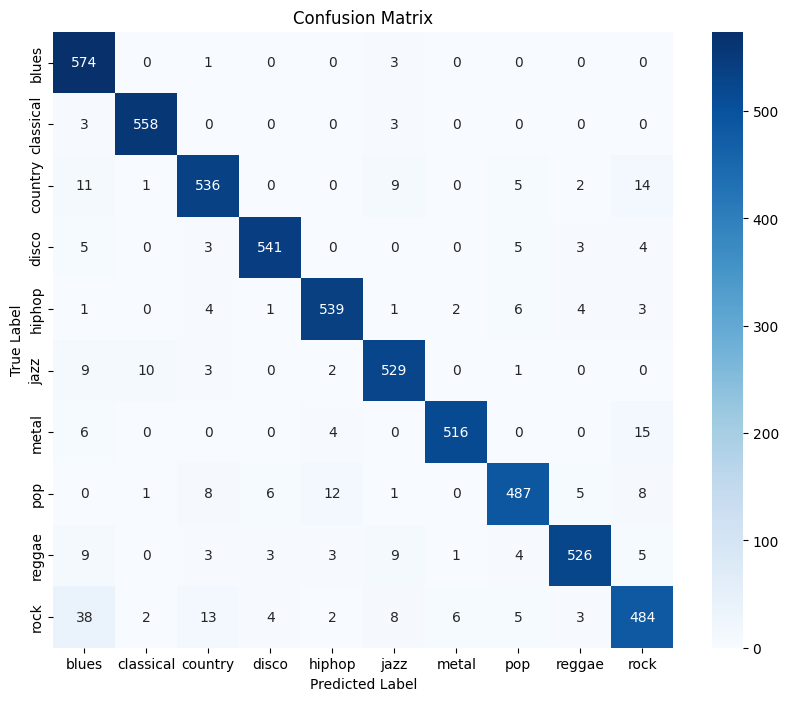

              precision    recall  f1-score   support

       blues       0.88      0.99      0.93       578
   classical       0.98      0.99      0.98       564
     country       0.94      0.93      0.93       578
       disco       0.97      0.96      0.97       561
      hiphop       0.96      0.96      0.96       561
        jazz       0.94      0.95      0.95       554
       metal       0.98      0.95      0.97       541
         pop       0.95      0.92      0.94       528
      reggae       0.97      0.93      0.95       563
        rock       0.91      0.86      0.88       565

    accuracy                           0.95      5593
   macro avg       0.95      0.95      0.95      5593
weighted avg       0.95      0.95      0.95      5593



In [5]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Set model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report (accuracy per class)
print(classification_report(all_labels, all_preds, target_names=genre_labels))

#### Test Accuracy Table

In [6]:
from collections import defaultdict

# Initialize dictionary to track accuracy per genre
genre_correct = defaultdict(int)
genre_total = defaultdict(int)

# Compute accuracy for each genre
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for label, pred in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            genre_total[label] += 1
            if label == pred:
                genre_correct[label] += 1

# Print accuracy per genre
print("\nGenre-wise Test Accuracy:")
print("-" * 40)
for i, genre in enumerate(genre_labels):
    accuracy = 100 * genre_correct[i] / genre_total[i] if genre_total[i] > 0 else 0
    print(f"{genre:15s} | Accuracy: {accuracy:.2f}%")


Genre-wise Test Accuracy:
----------------------------------------
blues           | Accuracy: 99.31%
classical       | Accuracy: 98.94%
country         | Accuracy: 92.73%
disco           | Accuracy: 96.43%
hiphop          | Accuracy: 96.08%
jazz            | Accuracy: 95.49%
metal           | Accuracy: 95.38%
pop             | Accuracy: 92.23%
reggae          | Accuracy: 93.43%
rock            | Accuracy: 85.66%


### Testing
using real recordings

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# Function to convert a 3-second audio segment to a mel-spectrogram
def save_mel_spectrogram(y, sr, output_image_path, n_mels=128):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Paths
PATH_MP3 = "./data/test/recorded_music"
PATH_IMG = "./data/test/genres_img/"
sr = 48000  # Sampling rate
skip = []   

os.makedirs(PATH_IMG, exist_ok=True)

# Convert all M4A files to a single mel spectrogram
for genre in os.listdir(PATH_MP3):
    if genre not in skip:
        genre_path = os.path.join(PATH_MP3, genre)
        genre_img_path = os.path.join(PATH_IMG, genre)
        os.makedirs(genre_img_path, exist_ok=True)   
        
        for music in os.listdir(genre_path):
            wav_path = os.path.join(genre_path, music)
            y, sr = librosa.load(wav_path, sr=sr, mono=True, res_type="kaiser_fast")
            segment_length = sr * 3  
            segment = y[:segment_length]
            output_img_path = os.path.join(genre_img_path, f"{music[:-4]}.png")  
            save_mel_spectrogram(segment, sr, output_img_path)

        print(f"Finished: {genre}")
    else:
        print(f"Skipped: {genre}")

C:\Users\Griff\AppData\Local\Temp\ipykernel_24640\1638385151.py:39: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(wav_path, sr=sr, mono=True, res_type="kaiser_fast")
c:\Users\Griff\Documents\School\CS484\Project\.venv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\Griff\AppData\Local\Temp\ipykernel_24640\1638385151.py:39: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(wav_path, sr=sr, mono=True, res_type="kaiser_fast")
c:\Users\Griff\Documents\School\CS484\Project\.venv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype

Finished: blues
Finished: classical
Finished: country
Finished: disco
Finished: hiphop
Finished: jazz
Finished: metal
Finished: pop
Finished: reggae
Finished: rock


In [4]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os

# Define paths
MODEL_PATH = "music_genre_cnn.pth"
TEST_DATA_PATH = "./data/test/genres_img"

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicGenreCNN(10)  # Create an instance of model
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))  # Load weights
model.to(device)
model.eval()  # Set model to evaluation mode

# Define preprocessing for spectrogram images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Adjust size based on model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Get genre classes from the test folder structure
genres = sorted(os.listdir(TEST_DATA_PATH))

# Function to classify an image
def predict_genre(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        predicted_idx = torch.argmax(output, dim=1).item()
        predicted_genre = genres[predicted_idx] 
    
    return predicted_genre

# Loop through test images and classify them
results = {}

for genre in genres:
    genre_path = os.path.join(TEST_DATA_PATH, genre)
    results[genre] = {"correct": 0, "total": 0}

    for img_name in os.listdir(genre_path):
        img_path = os.path.join(genre_path, img_name)
        predicted_genre = predict_genre(img_path)

        # Track accuracy
        results[genre]["total"] += 1
        if predicted_genre == genre:
            results[genre]["correct"] += 1

# Print results
for genre, stats in results.items():
    accuracy = (stats["correct"] / stats["total"]) * 100 if stats["total"] > 0 else 0
    print(f"{genre}: {accuracy:.2f}% ({stats['correct']}/{stats['total']} correct)")

blues: 66.67% (2/3 correct)
classical: 33.33% (1/3 correct)
country: 0.00% (0/3 correct)
disco: 0.00% (0/3 correct)
hiphop: 0.00% (0/3 correct)
jazz: 0.00% (0/3 correct)
metal: 66.67% (2/3 correct)
pop: 0.00% (0/3 correct)
reggae: 33.33% (1/3 correct)
rock: 100.00% (3/3 correct)
